# Percentile Analysis

In [46]:
import sys

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
from scipy.stats import norm
import seaborn as sns

sys.path.append('..')
from constants import MIN_DAYSAHEAD, MAX_DAYSAHEAD, BIN_FREQ_PER_DAY

sns.set()

# Model

In [50]:
df = pd.DataFrame()

for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD+1):
    df_cur = pd.read_csv(f'../data/processed/method2/k35/delta_window4/percentiles_daysahead{i}_R000.csv')
    df['TruePercentile'] = df_cur['TruePercentile']
    df[f'{i} Days'] = df_cur['ObservedPercentile']

df

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,4.788592,5.569399,5.609224,5.226068,5.577391,5.586418,5.196427
2,10,9.465097,10.976825,11.037706,10.639227,11.192214,10.561139,10.786334
3,15,14.216327,16.141291,16.428794,16.264422,16.601160,15.885400,15.976516
4,20,18.793200,21.542487,21.819882,21.571562,22.153597,21.184695,21.360315
5,25,23.401208,26.787939,26.986600,26.853757,27.450246,26.253043,26.169508
6,30,28.401519,32.369798,32.253038,31.792953,32.584690,31.483678,31.209793
7,35,33.457874,37.260154,37.650358,36.913003,37.762805,36.439673,36.231341
8,40,38.420823,42.050835,42.736055,41.852198,42.572837,41.102303,41.096746
9,45,42.941653,46.829056,47.510128,46.236358,47.613700,45.846077,45.787271


In [51]:
df[df.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,23.401208,26.787939,26.986600,26.853757,27.450246,26.253043,26.169508
10,50,47.530980,51.339397,52.147086,50.757717,52.099320,50.209101,50.078071
15,75,72.563671,74.333416,73.331256,72.466480,73.391977,71.911866,70.807570


In [52]:
df_err = pd.DataFrame({f'{i} Days' : df['TruePercentile'] - df[f'{i} Days'] for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)})
df_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.211408,-0.569399,-0.609224,-0.226068,-0.577391,-0.586418,-0.196427
2,0.534903,-0.976825,-1.037706,-0.639227,-1.192214,-0.561139,-0.786334
3,0.783673,-1.141291,-1.428794,-1.264422,-1.601160,-0.885400,-0.976516
4,1.206800,-1.542487,-1.819882,-1.571562,-2.153597,-1.184695,-1.360315
5,1.598792,-1.787939,-1.986600,-1.853757,-2.450246,-1.253043,-1.169508
6,1.598481,-2.369798,-2.253038,-1.792953,-2.584690,-1.483678,-1.209793
7,1.542126,-2.260154,-2.650358,-1.913003,-2.762805,-1.439673,-1.231341
8,1.579177,-2.050835,-2.736055,-1.852198,-2.572837,-1.102303,-1.096746
9,2.058347,-1.829056,-2.510128,-1.236358,-2.613700,-0.846077,-0.787271


# Baseline

In [20]:
df_baseline= pd.read_csv(f'../data/processed/baseline/percentiles_R000.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/baseline/percentiles_R000.csv'

In [22]:
df[df.TruePercentile.apply(lambda x: x in [25, 50, 75])]

,TruePercentile,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
5,25,23.089856,25.236731,27.198504,26.049267,26.239940,25.965920,25.107738
10,50,46.858459,49.233740,52.109691,49.298410,50.308815,49.765932,48.204360
15,75,71.442805,72.115624,73.119352,70.695354,71.002558,70.675988,68.752732


In [23]:
df_baseline_err = pd.DataFrame({f'{i} Days' : df_baseline['TruePercentile'] - df_baseline[f'{i} Days'] for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1)})

NameError: name 'df_baseline' is not defined

In [55]:
df_baseline_err

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
1,-1.25%,-1.15%,-1.5%,-1.22%,-1.43%,-1.34%,-1.61%
2,-2.18%,-2.34%,-2.35%,-2.79%,-2.88%,-2.88%,-3.55%
3,-3.4%,-3.52%,-3.55%,-4.02%,-3.93%,-4.02%,-4.97%
4,-4.27%,-4.6%,-4.54%,-5.12%,-5.47%,-5.38%,-6.29%
5,-5.1%,-5.49%,-5.31%,-5.95%,-6.6%,-6.39%,-7.34%
6,-5.86%,-5.9%,-6.27%,-6.66%,-7.12%,-7.37%,-8.07%
7,-6.14%,-6.48%,-7.11%,-7.58%,-7.81%,-7.68%,-8.58%
8,-6.35%,-6.71%,-7.54%,-7.71%,-8.08%,-8.0%,-8.57%
9,-6.32%,-6.47%,-7.57%,-7.53%,-8.39%,-7.95%,-8.47%


# Comparison Plot 

In [45]:
def make_plot(df_plot, title, ax):
    for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
        ax.plot(df_plot.TruePercentile, df_plot[f'{i} Days'], 'o-', label=f'{i} Days')
    ax.plot(df_plot.TruePercentile, df_plot.TruePercentile, color='red', label='Identity', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('True Percentile')
    ax.set_ylabel('Observed Percentile')
    ax.set_xlim(0, 101)
    ax.set_ylim(0, 101)
    ax.set_yticklabels([str(p) + '%' for p in ax.get_xticks()]) 
    ax.set_xticklabels([str(p) + '%' for p in ax.get_xticks()]) 
    ax.set_title(title, fontweight='bold') 

/tmp/ipykernel_2613186/214224795.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(p) + '%' for p in ax.get_xticks()])
/tmp/ipykernel_2613186/214224795.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(p) + '%' for p in ax.get_xticks()])


NameError: name 'df_baseline' is not defined

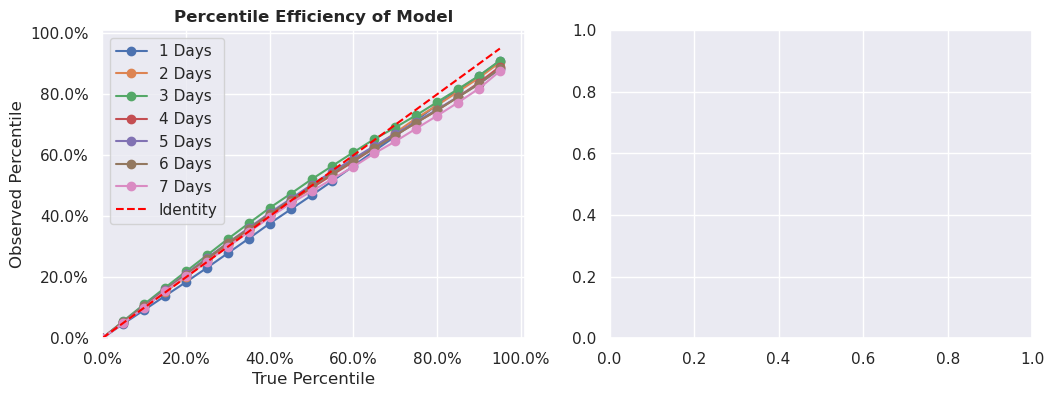

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

make_plot(df, 'Percentile Efficiency of Model', axes[0])
make_plot(df_baseline, 'Percentile Efficiency of Simple Baseline', axes[1])
plt.savefig('../plots.percentile_efficiency.png', dpi=300)

In [56]:
np.abs(df_baseline_err) - np.abs(df_err) 

,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days,7 Days
0,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
1,0.542%,1.15%,0.841%,0.798%,0.861%,0.943%,1.49%
2,0.705%,2.21%,1.76%,1.73%,1.7%,1.87%,3.25%
3,1.01%,3.51%,2.57%,2.61%,2.66%,2.77%,4.42%
4,1.17%,4.59%,3.53%,3.19%,3.98%,3.84%,5.83%
5,1.35%,5.45%,4.11%,3.84%,5.12%,4.48%,6.88%
6,1.87%,5.59%,5.1%,4.45%,5.47%,5.41%,8.04%
7,1.74%,6.17%,6.05%,5.23%,6.05%,5.84%,8.43%
8,1.63%,5.96%,6.55%,5.52%,6.54%,6.44%,7.61%
9,1.48%,5.34%,6.7%,5.86%,7.07%,6.77%,7.15%
